In [1]:
import cv2 
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import sys
import os

project_root = os.path.abspath(os.path.join("..", "ImgProcTools"))
sys.path.append(project_root)

In [3]:
import core
import utils

In [4]:
# Ruta a la carpeta de ejemplos
image_dir = "images"

## Carga de Imágenes con `image_loader`

En esta sección exploraremos cómo cargar imágenes utilizando funciones implementadas en el módulo `core.image_loader`. En lugar de simplemente usar `cv2.imread`, el sistema aplica procesamiento extra para manejar correctamente diferentes tipos de imágenes, incluyendo GIFs, TIFFs y formatos en escala de grises o color.



In [5]:
from core import load_image
from utils import show_image

Mostrando imagen: lenna.tiff


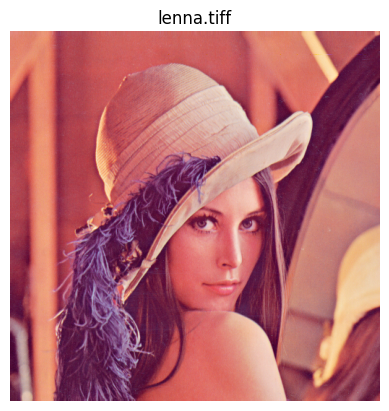

Mostrando imagen: jelly_beans.tiff


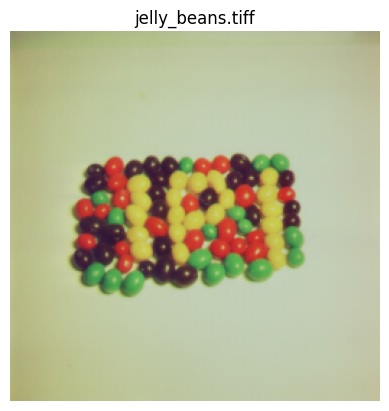

Mostrando imagen: monkey.tiff


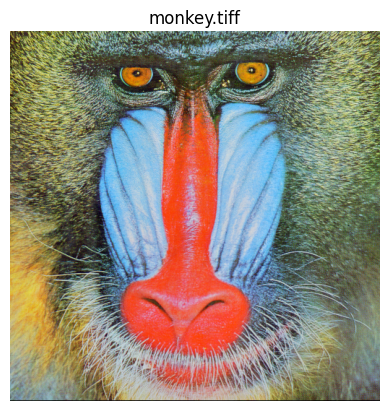

Mostrando imagen: fruit.tiff


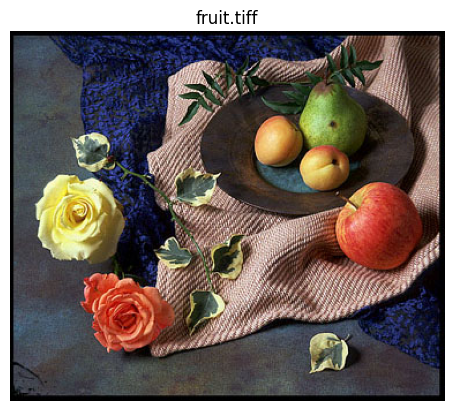

In [6]:
# Lista de nombres de archivo a cargar
image_files = [
    "lenna.tiff",
    "jelly_beans.tiff",
    "monkey.tiff",
    "fruit.tiff"
]

# Carga y visualización de las imágenes
for filename in image_files:
    image_path = os.path.join(image_dir, filename)
    image = load_image(image_path)
    
    print(f"Mostrando imagen: {filename}")
    show_image(image, title=filename)


## Filtros en el Dominio de la Frecuencia

El módulo `core.frecuency_filters` nos permite aplicar transformaciones en el dominio de la frecuencia, algo fundamental cuando se busca trabajar con el contenido espectral de una imagen. Aquí no usamos directamente OpenCV sino una lógica de aplicación de máscaras sobre la transformada de Fourier, lo que permite modificar componentes específicas de frecuencia de manera más fina y controlada.

### Planteamiento

Queremos aplicar un filtro de paso bajo para suavizar una imagen, eliminando detalles de alta frecuencia. Este tipo de filtro es útil en tareas como reducción de ruido o desenfoque. Para lograrlo:

- Cargaremos una imagen.
- Calcularemos su transformada de Fourier.
- Aplicaremos una máscara de paso bajo.
- Reconstruiremos la imagen filtrada.


In [7]:
from core import apply_fft_filter, create_ideal_filter
from utils import side_by_side

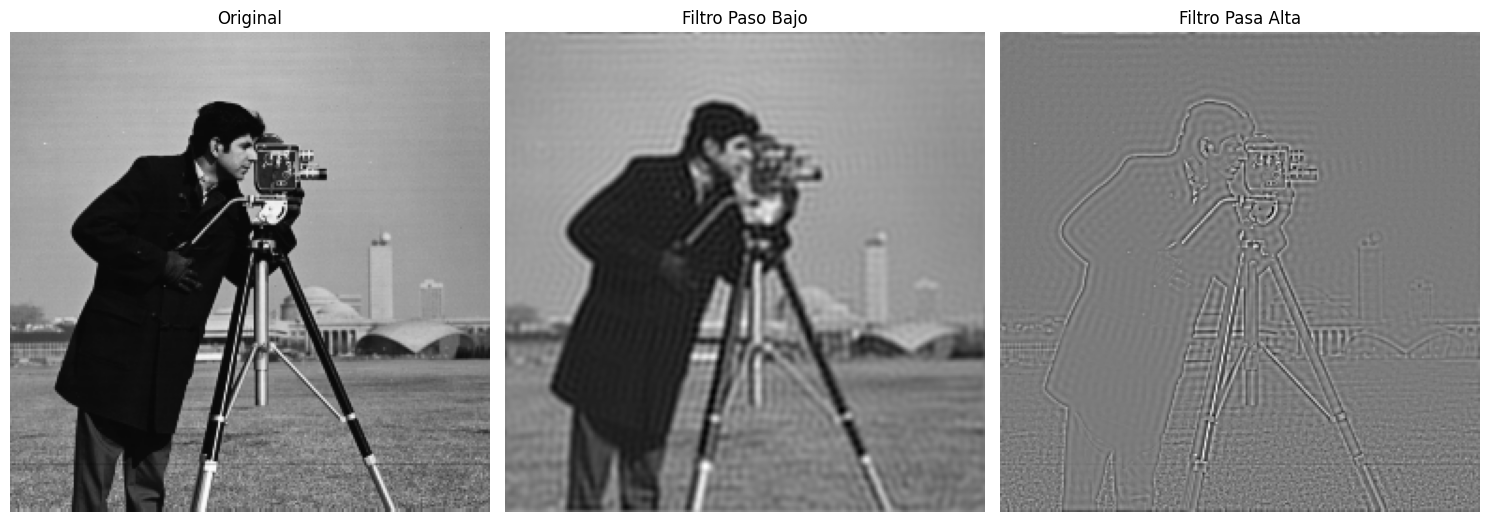

In [8]:
# Ruta de la imagen
image_path = "images/cameraman.tiff"

# Carga la imagen en escala de grises
image = load_image(image_path)
rows, cols, _= image.shape

# Creamos filtro pasa bajas
low_pass = create_ideal_filter((rows, cols), radius=50, high_pass=False)
high_pass = create_ideal_filter((rows, cols), radius=50, high_pass=True)

# Aplica filtro de paso bajo (definido por su tamaño de corte)
filtered_image = apply_fft_filter(image, low_pass)
filtered_image_high = apply_fft_filter(image, high_pass)


# Visualiza resultado original vs filtrado
side_by_side([image, filtered_image, filtered_image_high], ["Original", "Filtro Paso Bajo", "Filtro Pasa Alta"])


## Mejora del Contraste con `image_enhancement`

El procesamiento de imágenes muchas veces requiere resaltar detalles que no se perciben fácilmente en la imagen original. En esta sección usaremos una función de `core.image_enhancement` que realiza una mejora local del contraste mediante *Adaptive Histogram Equalization*. 

### Planteamiento

El objetivo es mejorar el contraste de una imagen usando una técnica de ecualización adaptativa, que permite corregir zonas oscuras o muy brillantes sin afectar el resto de la imagen. Este tipo de mejora es especialmente útil cuando hay condiciones de iluminación desiguales.



In [12]:
from core import clahe

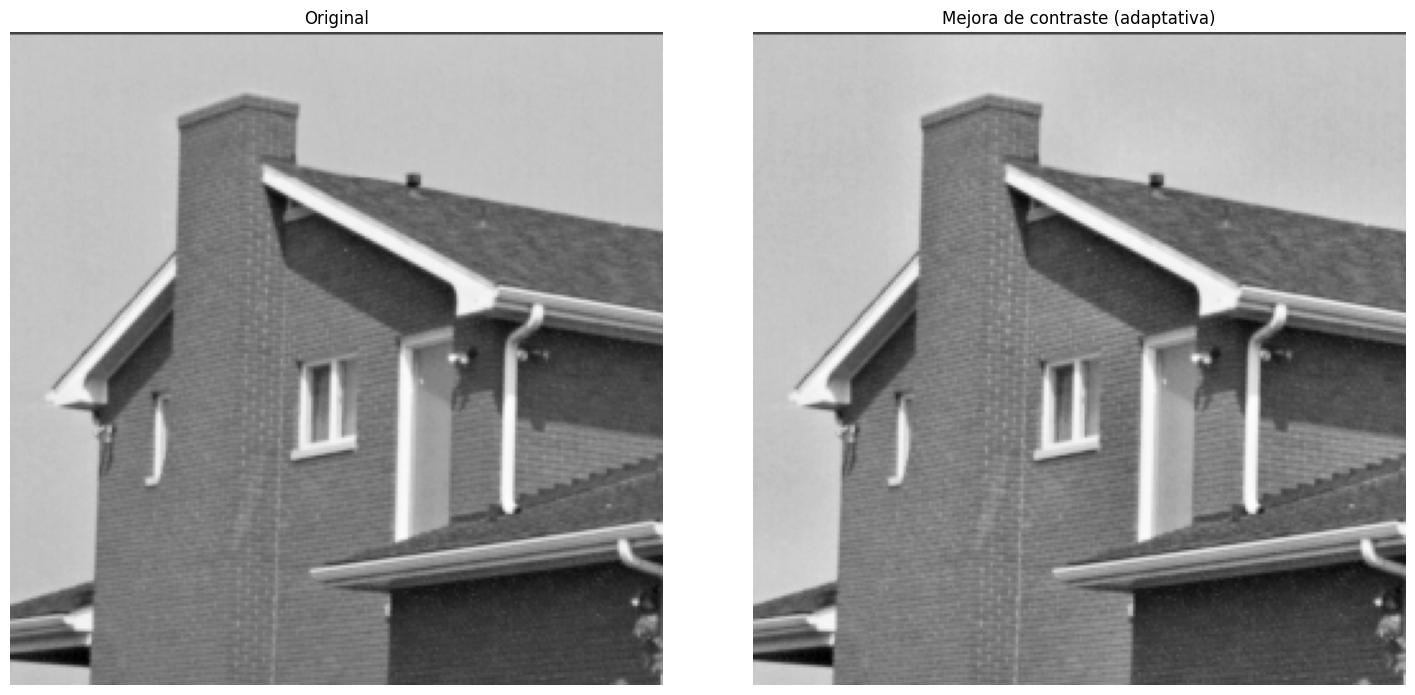

In [17]:
image_path = "images/house.tiff"
image = load_image(image_path, as_gray=True)

enhanced_image = clahe(image, clip_limit=0.03, grid_size=(8, 8))

side_by_side([image, enhanced_image], ["Original", "Mejora de contraste (adaptativa)"])


## Filtro de Bordes con Transformación Previa

Procesar imágenes a menudo requiere preparar la imagen antes de aplicar un filtro. Por ejemplo, aplicar un filtro de bordes sobre una imagen rotada puede revelar detalles que no eran tan evidentes antes de la transformación.


### Planteamiento

Vamos a rotar una imagen ligeramente y luego aplicar un filtro de bordes personalizado. Esto puede ser útil para análisis de texturas en orientaciones específicas, por ejemplo, en inspección de calidad de superficies o estructuras repetitivas.



In [21]:
from core import rotate, apply_kernel

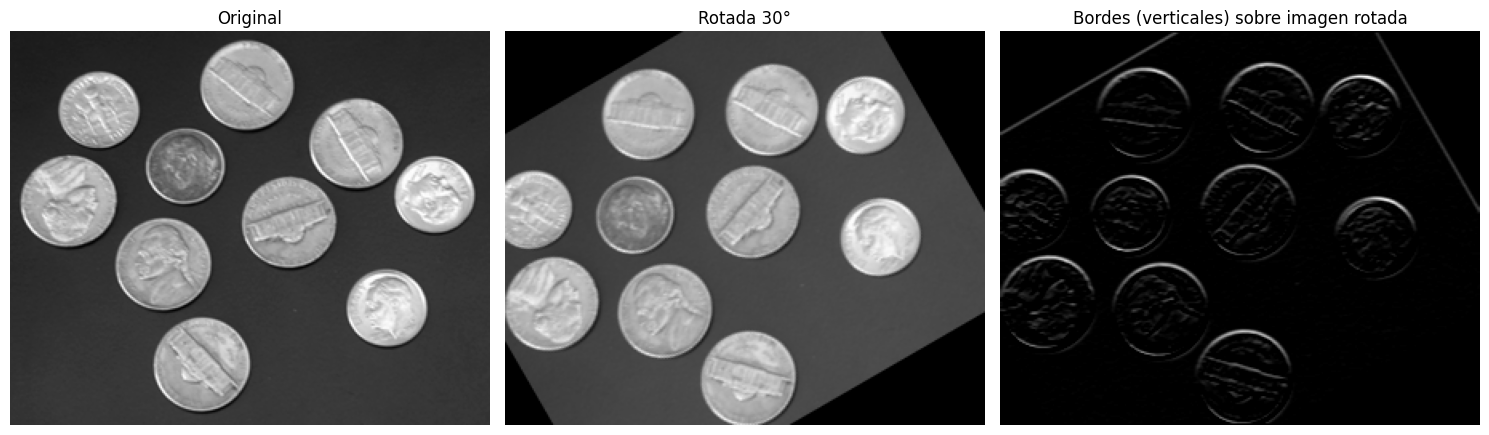

In [23]:
image_path = "images/coins.tiff"
image = load_image(image_path, as_gray=True)

# Rotamos la imagen 30 grados sin recorte
rotated = rotate(image, angle=30)

#  Filtro de detección de bordes tipo Sobel modificado
custom_kernel = np.array([
    [-1, -2, -1],
    [ 0,  0,  0],
    [ 1,  2,  1]
])

# Aplicamos el filtro sobre la imagen rotada
filtered = apply_kernel(rotated, custom_kernel)

side_by_side([image, rotated, filtered],
            ["Original", "Rotada 30°", "Bordes (verticales) sobre imagen rotada"])

## Análisis de Componentes Conectados y Contornos

La detección de objetos en una imagen suele requerir múltiples etapas: primero resaltar las regiones de interés (por ejemplo, mediante umbralización o filtrado), luego segmentarlas y finalmente analizarlas.

### Planteamiento

Usaremos una imagen con múltiples objetos (por ejemplo, monedas), la convertiremos a binaria y analizaremos las regiones conectadas. Extraeremos contornos y mostraremos métricas como área o número de regiones.

---


In [32]:
from core import (
    simple_threshold, 
    adaptive_threshold, 
    otsu_threshold, 
    find_contours,
    approximate_contour, 
    detect_shapes
)

In [33]:
image_path = "images/multicoins.tiff"

In [42]:
def run_image_analysis(path: str, grayscale: bool = True, ) -> None:
    image = load_image(path, as_gray=grayscale)
    show_image(image, title="Imagen original")

    # Verificamos si la imagen está en escala de grises
    if len(image.shape) != 2:
        raise ValueError("Se requiere una imagen en escala de grises para umbralización y análisis de formas.")

    # 1. Thresholding simple
    _, binary_simple = simple_threshold(image, threshold_value=120, method="binary")
    show_image(binary_simple, title="Umbral Simple")

    # 2. Thresholding adaptativo
    binary_adaptive = adaptive_threshold(image, method="gaussian", threshold_type="binary")
    show_image(binary_adaptive, title="Umbral Adaptativo")

    # 3. Thresholding de Otsu
    _, binary_otsu = otsu_threshold(image, threshold_type="binary")
    show_image(binary_otsu, title="Umbral Otsu")

    # 4. Detección de contornos y formas sobre la imagen binaria de Otsu
    shapes = detect_shapes(binary_otsu)

    # Dibujar los contornos detectados sobre una copia en BGR
    output = cv2.cvtColor(binary_otsu, cv2.COLOR_GRAY2BGR)
    for name, contour in shapes:
        approx = approximate_contour(contour)
        cv2.drawContours(output, [approx], -1, (0, 255, 0), 2)
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            cv2.putText(output, name, (cx - 20, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

    show_image(output, title="Formas Detectadas")


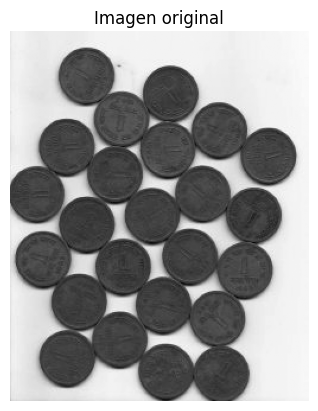

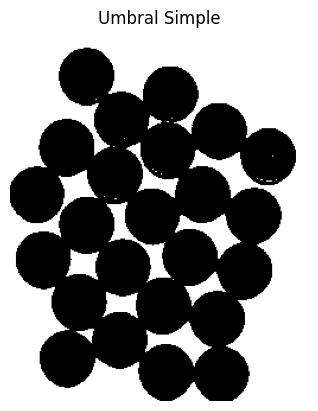

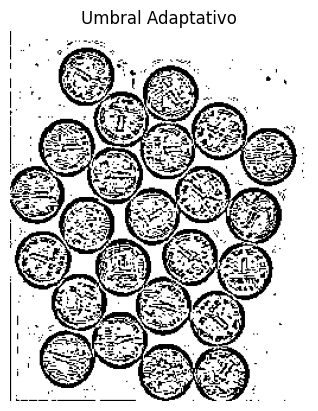

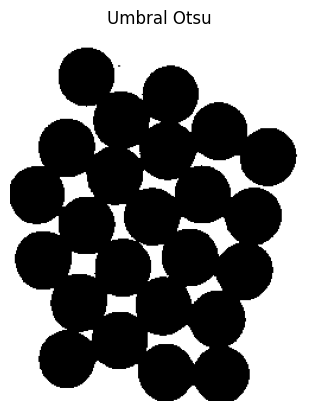

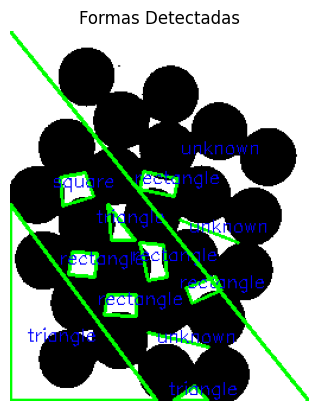

In [43]:
run_image_analysis(path=image_path)